In [1]:
import os
import pandas as pd
import torch
import numpy as np
import copy
import pprint
from sklearn.metrics import mean_absolute_error

DATA_PATH = "../data/ts_practice/"
SEED = 42

In [2]:
train_df = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
test_df = pd.read_csv(os.path.join(DATA_PATH, "test.csv"))

In [3]:
train_df.head()

Date  store  product  number_sold
0  2010-01-01      0        0          801
1  2010-01-02      0        0          810
2  2010-01-03      0        0          818
3  2010-01-04      0        0          796
4  2010-01-05      0        0          808

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230090 entries, 0 to 230089
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Date         230090 non-null  object
 1   store        230090 non-null  int64 
 2   product      230090 non-null  int64 
 3   number_sold  230090 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.0+ MB


In [5]:
train_df["Date"] = pd.to_datetime(train_df["Date"])
test_df["Date"] = pd.to_datetime(test_df["Date"])

In [6]:
def MAPE(y_true, y_pred):  # Mean Absolute Percentage Error
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def date_feature_eng(df):  # Feature Engineering
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Day"] = df["Date"].dt.day
    df.drop("Date", axis=1, inplace=True)
    return df

In [7]:
y_train = train_df["number_sold"]
X_train = train_df.drop("number_sold", axis=1)
X_train = date_feature_eng(X_train)

y_test = test_df["number_sold"]
X_test = test_df.drop("number_sold", axis=1)
X_test = date_feature_eng(X_test)

In [8]:
from sklearn.linear_model import LinearRegression

LR = LinearRegression()
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)

lr_mape = MAPE(y_test, y_pred)

print(f"Linear Regression MAPE: {lr_mape:.2f}%")

Linear Regression MAPE: 29.17%


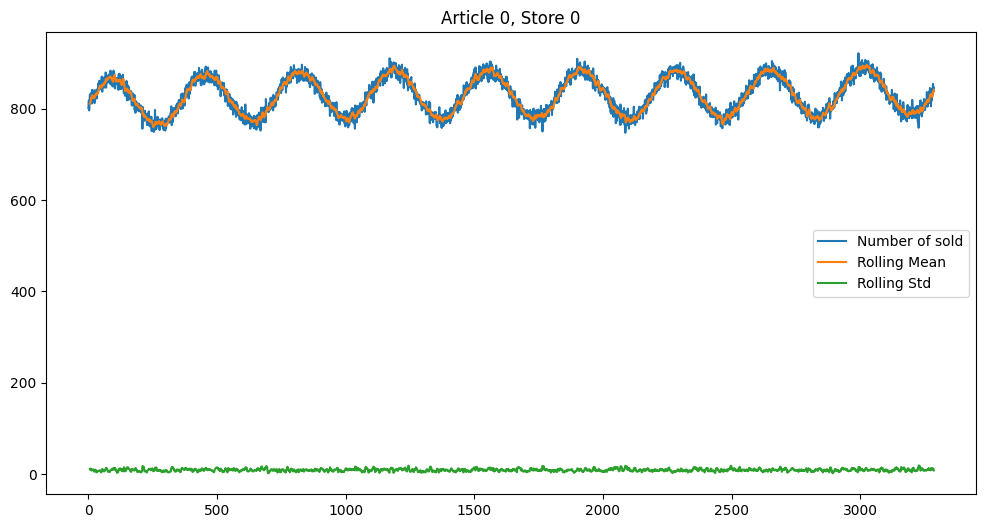

In [9]:
import matplotlib.pyplot as plt

a0s0 = train_df[(train_df["product"] == 0) & (train_df["store"] == 0)]

rolling_means = a0s0["number_sold"].rolling(window=7).mean()
rolling_std = a0s0["number_sold"].rolling(window=7).std()

plt.figure(figsize=(12, 6))
plt.plot(a0s0["number_sold"], label="Number of sold")
plt.plot(rolling_means, label="Rolling Mean")
plt.plot(rolling_std, label="Rolling Std")
plt.legend()
plt.title("Article 0, Store 0")
plt.show()

In [10]:
# Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller


def dickey_fuller_test(series):
    result = adfuller(series)
    return result[1] <= 0.05

In [11]:
for i in range(5):
    for j in range(5):
        a_s = train_df[(train_df["product"] == i) & (train_df["store"] == j)]
        test = dickey_fuller_test(a_s["number_sold"])
        if not test:
            print(f"Article {i}, Store {j} is not stationary")

Article 0, Store 1 is not stationary
Article 0, Store 2 is not stationary
Article 0, Store 3 is not stationary
Article 0, Store 4 is not stationary
Article 1, Store 4 is not stationary
Article 2, Store 1 is not stationary
Article 2, Store 2 is not stationary
Article 4, Store 1 is not stationary
Article 4, Store 3 is not stationary


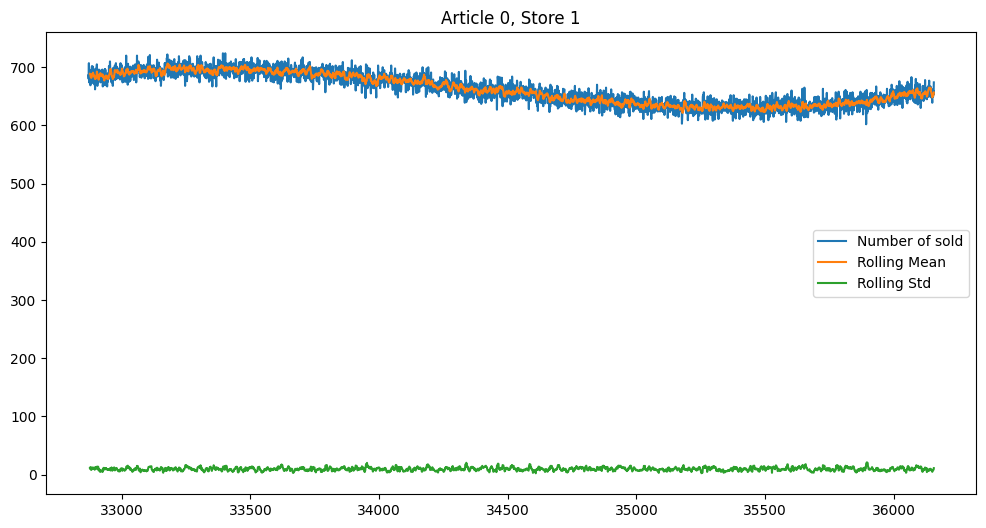

In [12]:
a0s1 = train_df[(train_df["product"] == 0) & (train_df["store"] == 1)]

rolling_means = a0s1["number_sold"].rolling(window=7).mean()
rolling_std = a0s1["number_sold"].rolling(window=7).std()

plt.figure(figsize=(12, 6))
plt.plot(a0s1["number_sold"], label="Number of sold")
plt.plot(rolling_means, label="Rolling Mean")
plt.plot(rolling_std, label="Rolling Std")
plt.legend()
plt.title("Article 0, Store 1")
plt.show()

In [13]:
from sklearn.preprocessing import StandardScaler


def convert_to_matrix(series, n_lags):
    series = series.reshape(-1, 1)
    scaler = StandardScaler()
    series = scaler.fit_transform(series).reshape(-1)
    X = []
    y = []
    for i in range(n_lags, len(series)):
        X.append(series[i - n_lags : i])
        y.append(series[i])
    return np.array(X), np.array(y), scaler

In [164]:
# for a0s0 :

n_lags = 50

X_a0s0, y_a0s0, scaler = convert_to_matrix(a0s0["number_sold"].values, n_lags)

X_a0s0_train = X_a0s0[: int(0.8 * len(X_a0s0))]
y_a0s0_train = y_a0s0[: int(0.8 * len(X_a0s0))]

X_a0s0_test = X_a0s0[int(0.8 * len(X_a0s0)) :]
y_a0s0_test = y_a0s0[int(0.8 * len(X_a0s0)) :]

features_num = 1
hidden_size = 32
n_layers = 2

In [165]:
# to tensors
X_a0s0_train = torch.tensor(X_a0s0_train).float()
y_a0s0_train = torch.tensor(y_a0s0_train).float()

X_a0s0_test = torch.tensor(X_a0s0_test).float()
y_a0s0_test = torch.tensor(y_a0s0_test).float()

In [178]:
class LSTM(torch.nn.Module):
    def __init__(self, hidden_size, num_layers, features_num):
        super(LSTM, self).__init__()
        self.lstm = torch.nn.LSTM(
            input_size=features_num,
            hidden_size=hidden_size // 2,
            num_layers=num_layers,
            batch_first=True,
        )
        self.lstm2 = torch.nn.LSTM(
            input_size=hidden_size // 2,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc = torch.nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = torch.nn.Linear(hidden_size // 2, 1)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.features_num = features_num
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):

        out, (hn, cn) = self.lstm(x)
        # out = self.relu(out)
        out, (hn, cn) = self.lstm2(out)
        # out = self.relu(out)
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        out = self.fc2(out)
        # out = self.sigmoid(out)
        return out

In [179]:
LSTM_model = LSTM(hidden_size, n_layers, features_num)
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(LSTM_model.parameters(), lr=0.001)
num_epochs = 50

In [180]:
print(X_a0s0.shape, y_a0s0.shape)
validation_size = int(0.2 * len(X_a0s0))
X_train = X_a0s0_train[:-validation_size]
y_train = y_a0s0_train[:-validation_size]
X_val = X_a0s0_train[-validation_size:]
y_val = y_a0s0_train[-validation_size:]

patience = 10

(3237, 50) (3237,)


In [181]:
batch_size = 32
best_val_loss = np.inf
for epoch in range(num_epochs):
    LSTM_model.train()  # Add this line to set the model in training mode
    for i in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        output = LSTM_model(
            X_train[i : i + batch_size].reshape(-1, n_lags, features_num)
        )
        loss = criterion(output, y_train[i : i + batch_size].reshape(-1, 1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(LSTM_model.parameters(), max_norm=1)
        optimizer.step()
    LSTM_model.eval()  # Add this line to set the model in evaluation mode
    val_loss = criterion(
        LSTM_model(X_val.reshape(-1, n_lags, features_num)), y_val.reshape(-1, 1)
    )
    if val_loss < best_val_loss:
        print(f"Epoch {epoch} best model saved with loss: {val_loss.item()}")
        best_state_dict = LSTM_model.state_dict()
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter == patience:
            print("Early stopping")
            break

LSTM_model.load_state_dict(best_state_dict)

Epoch 0 best model saved with loss: 0.8390318155288696
Epoch 1 best model saved with loss: 0.47442033886909485
Epoch 2 best model saved with loss: 0.3106030821800232
Epoch 3 best model saved with loss: 0.26020774245262146
Epoch 5 best model saved with loss: 0.24226082861423492
Epoch 7 best model saved with loss: 0.23218801617622375
Epoch 9 best model saved with loss: 0.22819681465625763
Epoch 12 best model saved with loss: 0.22720299661159515
Epoch 15 best model saved with loss: 0.226174995303154
Epoch 17 best model saved with loss: 0.22482359409332275
Epoch 22 best model saved with loss: 0.22276151180267334
Epoch 27 best model saved with loss: 0.22195318341255188
Epoch 28 best model saved with loss: 0.2218368947505951
Epoch 30 best model saved with loss: 0.22084839642047882
Early stopping


<All keys matched successfully>

In [182]:
X_test_a0s0 = torch.tensor(X_a0s0_test).float()
y_test_a0s0 = torch.tensor(y_a0s0_test.reshape(-1, 1)).float()

/var/folders/1q/12kg_kfs23s79nvvww18_nvc0000gn/T/ipykernel_42956/3325335721.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_a0s0 = torch.tensor(X_a0s0_test).float()
/var/folders/1q/12kg_kfs23s79nvvww18_nvc0000gn/T/ipykernel_42956/3325335721.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_a0s0 = torch.tensor(y_a0s0_test.reshape(-1, 1)).float()


In [183]:
LSTM_model.eval()

with torch.no_grad():
    y_pred_lstm = LSTM_model(X_test_a0s0.view(-1, n_lags, features_num))

lstm_mae = mean_absolute_error(y_test_a0s0, y_pred_lstm)

print(f"LSTM MAE: {lstm_mae:.2f}")

LSTM MAE: 0.23


In [184]:
LR = LinearRegression()
LR.fit(X_a0s0_train, y_a0s0_train)
y_pred_lr = LR.predict(X_test_a0s0)

mae = mean_absolute_error(y_test_a0s0, y_pred_lr)

print(f"Linear Regression MAE: {mae:.2f}")

Linear Regression MAE: 0.22


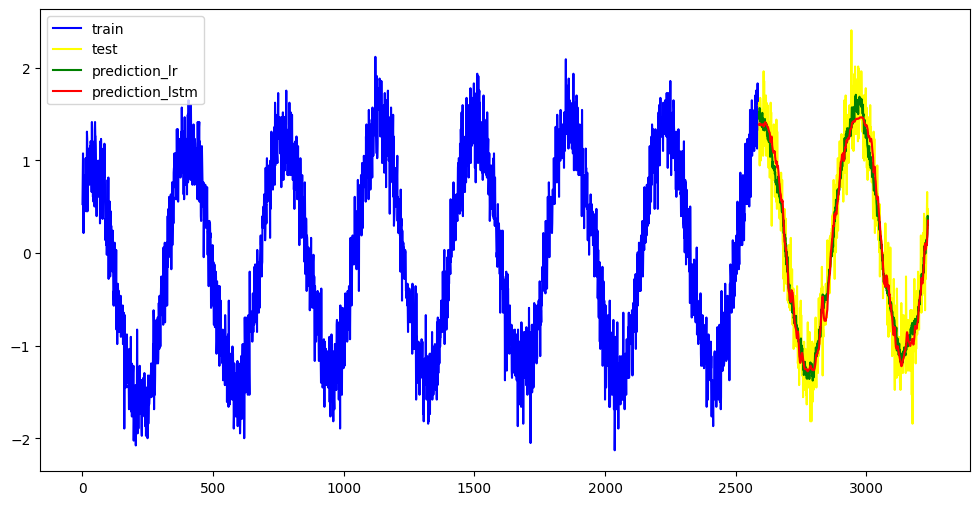

In [185]:
# plot train in blue, test in yellow, and prediction in green
plt.figure(figsize=(12, 6))
plt.plot(y_a0s0_train, color="blue", label="train")
plt.plot(
    range(len(y_a0s0_train), len(y_a0s0_train) + len(y_a0s0_test)),
    y_test_a0s0,
    color="yellow",
    label="test",
)
plt.plot(
    range(len(y_a0s0_train), len(y_a0s0_train) + len(y_a0s0_test)),
    y_pred_lr,
    color="green",
    label="prediction_lr",
)
plt.plot(
    range(len(y_a0s0_train), len(y_a0s0_train) + len(y_a0s0_test)),
    y_pred_lstm,
    color="red",
    label="prediction_lstm",
)
plt.legend()
plt.show()

In [186]:
predict_length = X_a0s0_test.shape[0]
X_a0s0_pred_lr = copy.deepcopy(np.asarray(X_a0s0_test[0]).reshape(-1, 1))
X_a0s0_pred_lstm = (
    torch.tensor(copy.deepcopy(np.asarray(X_a0s0_test[0]).reshape(-1, 1)))
    .float()
    .view(1, -1, 1)
)
predictions_lr = []
predictions_lstm = []
for i in range(predict_length):
    y_pred_lr = LR.predict(X_a0s0_pred_lr.reshape(1, -1))
    with torch.no_grad():
        y_pred_lstm = LSTM_model(X_a0s0_pred_lstm.reshape(1, -1, 1))
    predictions_lr.append(y_pred_lr)
    predictions_lstm.append(y_pred_lstm)
    X_a0s0_pred_lr = np.roll(X_a0s0_pred_lr, -1)
    X_a0s0_pred_lr[-1] = y_pred_lr
    X_a0s0_pred_lstm = torch.roll(X_a0s0_pred_lstm, -1, 1)
    X_a0s0_pred_lstm[:, -1, :] = y_pred_lstm

predictions_lstm = np.array(predictions_lstm).reshape(-1, 1)
predictions_lr = np.array(predictions_lr).reshape(-1, 1)

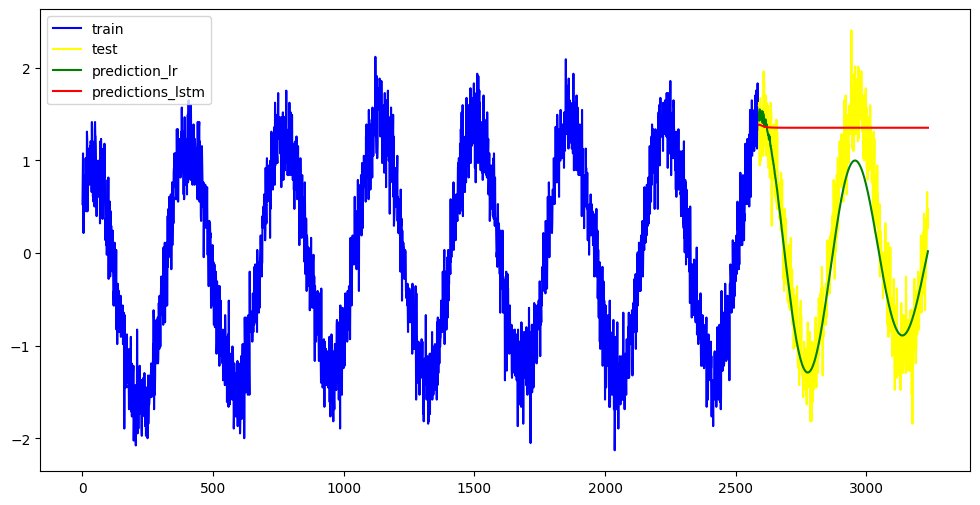

In [187]:
plt.figure(figsize=(12, 6))
plt.plot(y_a0s0_train, color="blue", label="train")
plt.plot(
    range(len(y_a0s0_train), len(y_a0s0_train) + len(y_a0s0_test)),
    y_test_a0s0,
    color="yellow",
    label="test",
)
plt.plot(
    range(len(y_a0s0_train), len(y_a0s0_train) + len(y_a0s0_test)),
    predictions_lr,
    color="green",
    label="prediction_lr",
)
plt.plot(
    range(len(y_a0s0_train), len(y_a0s0_train) + len(y_a0s0_test)),
    predictions_lstm,
    color="red",
    label="predictions_lstm",
)
plt.legend()
plt.show()

In [188]:
true_y = scaler.inverse_transform(y_test_a0s0.numpy().reshape(-1, 1))
pred_y_lr = scaler.inverse_transform(predictions_lr)
pred_y_lstm = scaler.inverse_transform(predictions_lstm)

# mape
lr_sequence_mape = MAPE(true_y, pred_y_lr)
lstm_sequence_mape = MAPE(true_y, pred_y_lstm)

print(f"Linear Regression Sequence MAPE: {lr_sequence_mape:.2f}%")
print(f"LSTM Sequence MAPE: {lstm_sequence_mape:.2f}%")

Linear Regression Sequence MAPE: 1.33%
LSTM Sequence MAPE: 6.39%


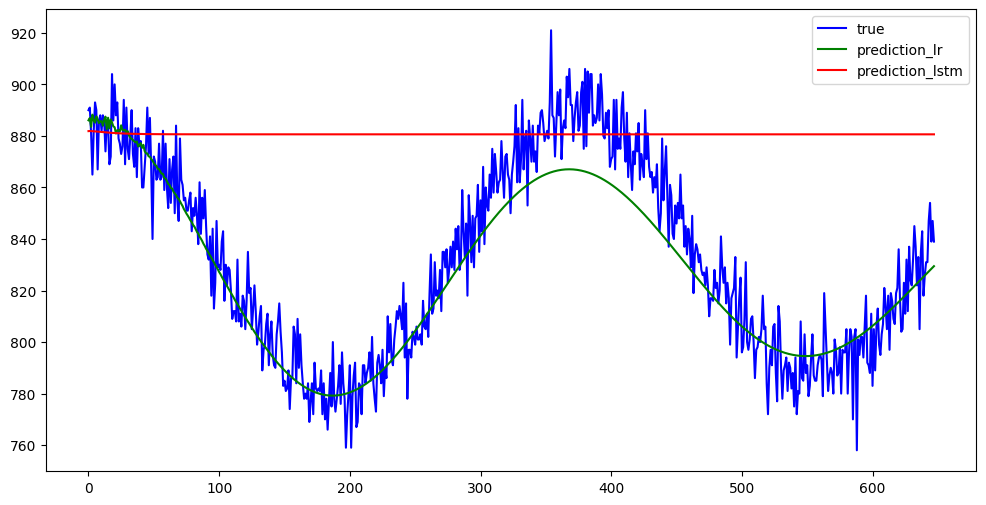

In [189]:
# plot
plt.figure(figsize=(12, 6))
plt.plot(true_y, color="blue", label="true")
plt.plot(pred_y_lr, color="green", label="prediction_lr")
plt.plot(pred_y_lstm, color="red", label="prediction_lstm")
plt.legend()
plt.show()